# 画图：观察攻击模型对噪声的适应性

In [1]:
import pandas as pd

import pandas as pd
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("stupidtree/[EXP]NaMOE_noise_adaption")

summary_list, config_list, name_list = [], [], []
for run in runs:
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })



In [2]:
# 只考虑GPT2-large
runs = []
for summary, config, name in zip(summary_list, config_list, name_list):
    if config['model_name']=='gpt2-large':
        runs.append((summary, config, name))

# attacker适应的所有的noise
noises = set([config['noise_scale_dxp'] for summary,config,name in runs])

In [3]:
result_map = {}
for sfl_noise in noises:
    atk_perform = {}
    for summary, config, name in runs:
        if config['noise_scale_dxp'] == sfl_noise:
            atk_perform[float(config['attacker_prefix'].split(':')[-1])] = summary['client0_DRA_b2tr_rgLf_avg']
    result_map[sfl_noise] = atk_perform

all_data = result_map
del all_data[0.4]
del all_data[0.3]
del all_data[0.35]
all_data

{0.1: {0.0: 0.1839045890708284,
  0.1: 0.4830791506384412,
  0.2: 0.4747607911976891,
  0.3: 0.37009877401034946,
  0.4: 0.21390503017590937,
  0.5: 0.20530018415297077,
  0.05: 0.28132789993261126,
  0.15: 0.4747905711961633,
  0.25: 0.4186766263077682,
  0.35: 0.2957305587649883},
 0.2: {0.0: 0.5993336391584068,
  0.2: 0.7627380832654401,
  0.3: 0.7318078286277138,
  0.4: 0.6115732592760758,
  0.5: 0.6099728259723416,
  0.1: 0.5765555295041527,
  0.05: 0.2824717208328882,
  0.15: 0.728871836422691,
  0.25: 0.766551413358995,
  0.35: 0.6697677823034427},
 0.15: {0.0: 0.34488437020824797,
  0.15: 0.6102541994577858,
  0.2: 0.6393614761123927,
  0.25: 0.5996632945723693,
  0.3: 0.5413458146296721,
  0.35: 0.44697689371154103,
  0.4: 0.3615514946609639,
  0.05: 0.28774719079701166,
  0.1: 0.5456346777396422},
 0.25: {0.0: 0.7975528936170662,
  0.15: 0.8014119454817832,
  0.2: 0.8403325470444681,
  0.25: 0.8429444078274851,
  0.3: 0.8355909628092465,
  0.35: 0.8132856463216924,
  0.4: 0.8

In [7]:
all_data = {k:{ sp:rg*100 for sp,rg in v.items()} for k,v in all_data.items() }

/tmp/ipykernel_3312796/1454068987.py:71: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


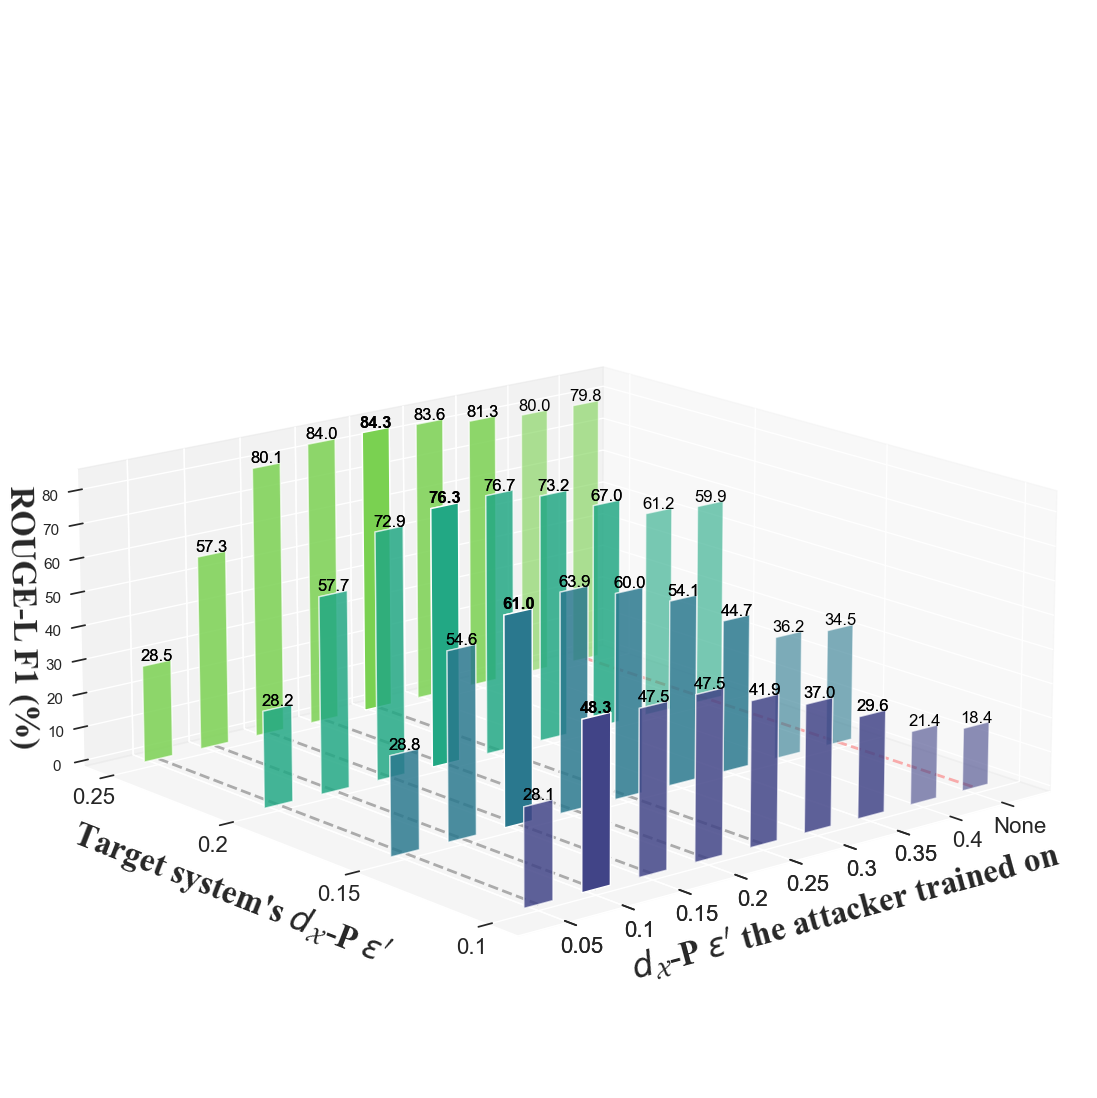

In [11]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(111, projection='3d')

# make the z axis shorter
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.0, 1.0, 0.6, 1]))

sns.set()
colors = sns.color_palette("viridis", n_colors=len(all_data))

sfl_dxps = sorted(list(all_data.keys()), reverse=True)
atk_dxp = list(all_data[sfl_dxps[0]].keys())

# Plotting each base_split
for i, sfl_dxp in enumerate(sfl_dxps):
    sps = []
    for sp, _ in all_data[sfl_dxp].items():
        if sp > 0.4:
            continue
        sps.append(sp)
    sps = sorted(sps)
    rouges = [all_data[sfl_dxp][sp] for sp in sps]
    sps = [sp if sp != 0 else 0.45 for sp in sps]
    sps = sps[1:] + sps[:-1]
    rouges = rouges[1:] + rouges[:-1]
    ax.bar(sps, rouges, zs=i, zdir='y', width=0.025, color=colors[3-i], alpha=0.6, label=sfl_dxp, zorder=2)
    ax.bar([sfl_dxp], [all_data[sfl_dxp][sfl_dxp]], zs=i, zdir='y', width=0.025, color=colors[3-i], alpha=1.0, zorder=3)
    for sp, rg in zip(sps, rouges):
        # make it bold
        ax.text(sp, i, rg + 2, f'{rg:.1f}', color='black', fontsize=12, ha='center', va='center', zorder=200,
                fontweight='bold' if sp == sfl_dxp else 'normal')

ax.set_xlabel('$d_{\mathcal{X}}$-P $\epsilon\'$ the attacker trained on', 
              fontsize=24, labelpad=22,fontname='Times New Roman', fontweight='bold')
ax.set_ylabel('Target system\'s $d_{\mathcal{X}}$-P $\epsilon\'$' , fontsize=24,
              fontname='Times New Roman',fontdict={'weight':'bold'},
              labelpad=22)
ax.set_zlabel('ROUGE-L F1 (%)',fontsize=24, 
              fontname='Times New Roman',fontdict={'weight':'bold'})
ax.set_yticks(range(len(sfl_dxps)))
ax.set_yticklabels([f'{sfl_dxp}' for sfl_dxp in sfl_dxps], fontsize=16)

ax.set_xticks(sps)
ax.set_xticklabels([f'{ad}' if ad != 0.45 else 'None' for ad in sps], fontsize=12)
# show all labels of x ticks


# show more labels on the x axis
# ax.set_xticks(sp_values)
# flip the x axis
# enlarge the x ticks size
ax.tick_params(axis='x', labelsize=16)
# draw dashed line alone the y axis where x=5
# for idx in [1,2,3,4, 8]:
#   ax.plot([idx, idx], [0, len(sfl_dxps)-1], [0, 0], color='black' if idx != 8 else 'red', linestyle='--', linewidth=2, alpha=0.3)

for idx in [0.05, 0.1, 0.15, 0.2, 0.25, 0.45]:
    ax.plot([idx, idx], [0, len(sfl_dxps) - 1], [0, 0], color='black' if idx != 0.45 else 'red', linestyle='--',
            linewidth=2, alpha=0.3)
ax.invert_xaxis()

ax.view_init(elev=15, azim=50)
# make the background transparent
plt.gca().patch.set_alpha(0)
# save the plot
plt.tight_layout()
plt.savefig('./noise_adaption.pdf')